First, create a function that gets the Mutual Information score for each feature. Then, get rid of features with mi = 0 (or features that are uninformative)

In [497]:
%load_ext autoreload
%autoreload 2
from src.functions import preprocess, evaluate_model, get_mi, plot_mi, interaction_features, drop_zeromi, kmeans_cluster, pca_transform, pca_interactions
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_train, df_test = preprocess()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [498]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = get_mi(X, y)
mi_scores.sort_values(ascending=False)

OverallQual             0.570187
Neighborhood_encoded    0.480704
GrLivArea               0.480315
YearBuilt               0.375320
GarageCars              0.370844
                          ...   
RoofStyle__Other        0.000000
LotConfig__Other        0.000000
BldgType__TwnhsE        0.000000
Exterior2nd__BrkFace    0.000000
RoofStyle__Gambrel      0.000000
Length: 161, dtype: float64

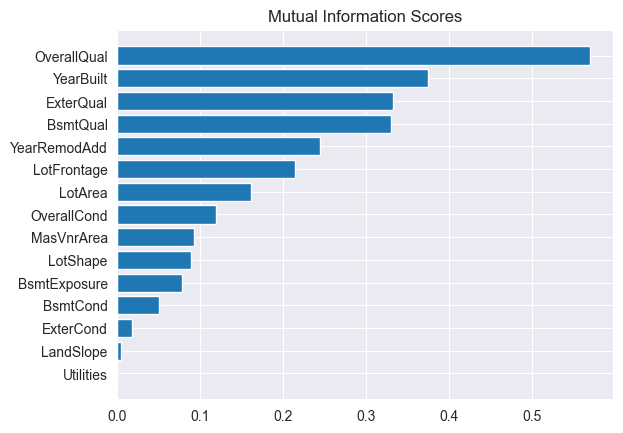

In [499]:
# plot top 15 scores
plot_mi(mi_scores.head(15));

In [500]:
mi_scores.sort_values(ascending=True)

LotConfig__FR2          0.000000
PoolQC                  0.000000
MiscFeature__Other      0.000000
MiscVal                 0.000000
MoSold                  0.000000
                          ...   
GarageCars              0.370844
YearBuilt               0.375320
GrLivArea               0.480315
Neighborhood_encoded    0.480704
OverallQual             0.570187
Length: 161, dtype: float64

Some features have a MI score of 0.0. It is better to drop those.

In [501]:
X = drop_zeromi(X, mi_scores)
X.shape

(1460, 138)

let's check the effect of dropping uninformative features

In [502]:
rmsle, mae = evaluate_model(X, y)

RMSLE: 0.13460
MAE: 17056.27558


# Next, create new features

Start with interaction/aggregate featuress

In [503]:
df_train, df_test = preprocess()

X = df_train.copy()
y = X.pop("SalePrice")

X = interaction_features(X)

mi_scores = get_mi(X, y)
X = drop_zeromi(X, mi_scores)

cols = ["TotalSF", "TotalBaths", "PorchSF", "BathsPerRoom", "PorchTypes", "Spaciousness", "LivLotRatio"]

# get mi scores for new features
X_cols = X[cols]
discrete = [X[c].nunique() <= 12 for c in cols]
mi = mutual_info_regression(X[cols], y, discrete_features=discrete, random_state=42)
mi_scores = pd.Series(mi, index=cols).sort_values(ascending=False)
print("\nMutual Information Scores:\n", mi_scores)


Mutual Information Scores:
 TotalSF         0.661641
TotalBaths      0.337633
BathsPerRoom    0.325973
Spaciousness    0.248966
PorchTypes      0.112505
PorchSF         0.100326
LivLotRatio     0.086442
dtype: float64


In [504]:
rmsle, mae = evaluate_model(X, y)

RMSLE: 0.13781
MAE: 17221.58328


informative features: TotalSF, AgeAtSale, TotalBaths, BathsPerRoom

### Next, KMeans clustering features

In [505]:
df_train, df_test = preprocess()

cluster_features = [
    "TotalSF",        # holistic size measure
    "TotalBaths",     # overall bathrooms
    "BathsPerRoom",   # efficiency/use ratio
    "LotArea",        # land size (adds location/lot info)
    "OverallQual",    # overall quality
]# ]

X = df_train.copy()
y = X.pop("SalePrice")

X = interaction_features(X)

X = interaction_features(X)
X = kmeans_cluster(X, cluster_features, k=5)

print(X["Clusters"].value_counts())

# mi analysis
discrete = [X[c].nunique() <= 12 for c in X.columns]
mi = mutual_info_regression(X, y, discrete_features=discrete, random_state=42)
mi_scores = pd.Series(mi, index=X.columns)

X = drop_zeromi(X, mi_scores)

print("MI Score for Clusters:", mi_scores.Clusters)
rmsle, mae = evaluate_model(X, y)

Clusters
1    585
0    368
4    260
2    243
3      4
Name: count, dtype: int64
MI Score for Clusters: 0.5088044124708226
RMSLE: 0.13821
MAE: 17013.79217


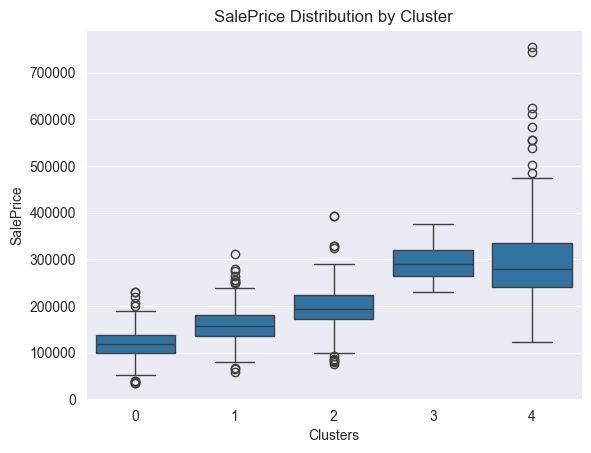

In [506]:
# Merge X and y for visualization only
plot_df = X.copy()
plot_df["SalePrice"] = y

sns.boxplot(data=plot_df, x="Clusters", y="SalePrice")
plt.title("SalePrice Distribution by Cluster")
plt.show()

### Next, PCA features

In [507]:
# first choose pca features:
pca_features = ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GarageArea", "LotArea", "MasVnrArea"]

df_train, df_test = preprocess()

X = df_train.copy()
y = X.pop("SalePrice")

X = interaction_features(X)

X = interaction_features(X)
X = kmeans_cluster(X, cluster_features, k=5)

mi_scores = get_mi(X, y)
X = drop_zeromi(X, mi_scores)

X_pca, loadings = pca_transform(X, pca_features)


In [508]:
pc_cols = [c for c in X_pca.columns if c.startswith("PC")]
print("PCA Features:", pc_cols)

PCA Features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']


In [509]:
pca_mi_scores = get_mi(X_pca[pc_cols], y)
print("PCA MI Scores:", pca_mi_scores)

PCA MI Scores: PC1    0.692072
PC2    0.434378
PC3    0.106336
PC4    0.165874
PC5    0.063573
dtype: float64


In [510]:
print(loadings)

                  PC1       PC2       PC3       PC4       PC5
GrLivArea    0.455639  0.409222  0.062844 -0.277633 -0.239769
TotalBsmtSF  0.459246 -0.339999 -0.055695 -0.174638 -0.215001
1stFlrSF     0.476710 -0.325563  0.008201 -0.233270 -0.252028
2ndFlrSF     0.126398  0.772869  0.061018 -0.113904 -0.051096
GarageArea   0.410016  0.007902 -0.198807 -0.086414  0.885444
LotArea      0.238354 -0.048810  0.877884  0.391962  0.126170
MasVnrArea   0.336648  0.105718 -0.423030  0.814819 -0.173860


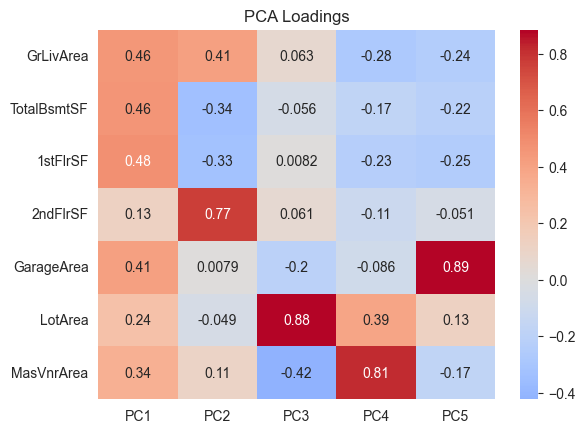

In [511]:
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings");

PC1 is shaped by overall size measures (GrLivArea, TotalBsmtSF, 1stFlrSF) while PC2 is strongly aligned with verticality (2ndFlrSF) versus ground-floor size.

PC3 heavily draws lot size (LotArea) as distinct from house size, and PC4 relies on masonry veneer and exterior features.

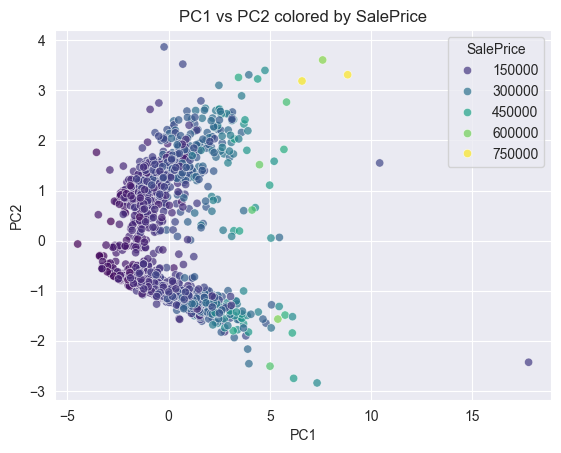

In [512]:
sns.scatterplot(x=X_pca["PC1"], y=X_pca["PC2"],
                hue=df_train["SalePrice"], palette='viridis', alpha=0.7)
plt.title("PC1 vs PC2 colored by SalePrice");

In [513]:
X_pca = pca_interactions(X_pca)

In [514]:
pc_cols = [c for c in X_pca.columns if c.startswith("PC")]
pca_mi_scores = get_mi(X_pca[pc_cols], y).sort_values(ascending=False)
print("PCA MI Scores:", pca_mi_scores)

PCA MI Scores: PC1            0.691212
PC2            0.432457
PC1_x_PC2      0.362863
PC1_x_PC4      0.198853
PC4            0.163599
PC1_div_PC3    0.149178
PC3            0.104599
PC5            0.062551
dtype: float64


In [515]:
evaluate_model(X_pca, y);

RMSLE: 0.13664
MAE: 17351.40138
